# Kaggle competition - Same Bagel
> The best group.

```
Sam Balana - 66602201 - sbalana
Ben Truong - -
Matt Marano - - mmarano
```

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Loading the data

In [6]:
X = np.genfromtxt('data/X_train.txt', delimiter=None)
Y = np.genfromtxt('data/Y_train.txt', delimiter=None)
X_submit = np.genfromtxt('data/X_test.txt', delimiter=None)

# Shuffle rows of X and Y in the same way
s = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(s)

X = X[s]
Y = Y[s]

print(X.shape)

(200000, 14)


## Splitting into training and test

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape)

(160000, 14)


## Scale for zero mean

In [8]:
# Scale the data, fitting only on training data
scaler = StandardScaler().fit(X_train)
#scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_submit = scaler.transform(X_submit)

# C-Support Vector

In [ ]:
from sklearn import svm

classifier = svm.SVC(probability=True, verbose=True, cache_size=3000)
classifier.fit(X_train, Y_train)

In [ ]:
predictions = classifier.predict_proba(X_test)
score = roc_auc_score(Y_test, predictions[:, 1])
print score

## Scores

```
80% split w/ scaled features: 0.683700689813552
```

# Linear Support Vector

In [18]:
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

linearClassifier = svm.LinearSVC()
clf = CalibratedClassifierCV(linearClassifier)
clf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [19]:
predictions = clf.predict_proba(X_test)
score = roc_auc_score(Y_test, predictions[:, 1])
print score

0.653035847176


## Scores

```
w/o scaling => 0.542754929198
w/ scaling => 0.653075161651
w/o scaling max_iter=100 => 0.612378292764
```

# Kernel Approximation

In [27]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier(loss="log", n_jobs=8)
clf.fit(X_features, Y_train)
predictions = clf.predict_proba(rbf_feature.transform(X_test))
score = roc_auc_score(Y_test, predictions[:, 1])
print score

0.597781577778


## Scores

```
w/o RBF loss="log" => 0.597828080836
w/ RBF loss="log" => 0.597781577778
```

# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeRegressor(
    max_depth=18,
    min_samples_leaf=12,
)
parameters = {
    'max_depth': np.arange(1,20),
}

grid = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=True)
grid.fit(X_train, Y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


0.693718464192
{}


## Scores

```
```

# AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

base_clf = DecisionTreeClassifier(
    max_depth=18,
    min_samples_leaf=12,
)
clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=100)
grid = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=True)
grid.fit(X_train, Y_train)
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Process PoolWorker-55:
Process PoolWorker-54:
Process PoolWorker-56:
Process PoolWorker-53:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-52:
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", 

KeyboardInterrupt: 

## Scores

All of these scores have been derived with a 80% split.

```
n_estimators=1000 => 0.69729716308
n_estimators=100, max_depth=9 => 0.732662275244
n_estimators=100, max_depth=18 => ~0.72
```

# Random Forest

<IPython.core.display.Javascript object>


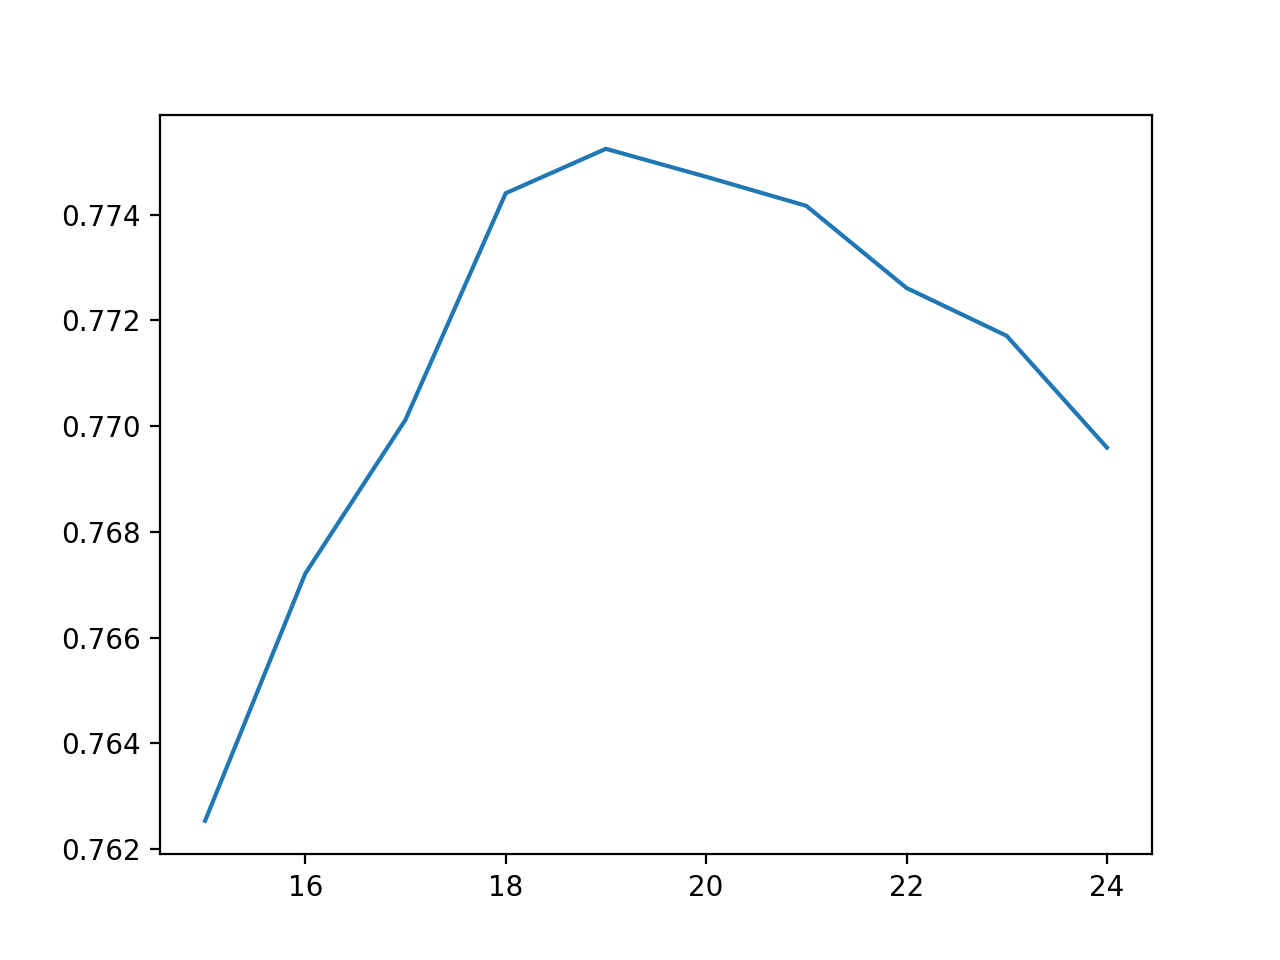

In [72]:
from sklearn.ensemble import RandomForestClassifier

def testDepth(d):
    clf = RandomForestClassifier(n_estimators=100, max_depth=d, n_jobs=8)
    clf.fit(X_train, Y_train)
    predictions = clf.predict_proba(X_test)
    score = roc_auc_score(Y_test, predictions[:, 1])
    return score

xs = []
ys = []

# 19
for d in np.arange(15,25,1):
    xs.append(d)
    ys.append(testDepth(d))
    
plt.plot(xs, ys)
plt.show()

In [41]:
from tempfile import mkdtemp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
cachedir = mkdtemp()

pca = PCA(n_components=13)
clf = RandomForestRegressor(
    n_estimators=10,
    n_jobs=-1
)
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', pca),
    ('clf', clf),
], memory=cachedir)
parameters = {
    'clf__max_depth': np.arange(8,25),
    'clf__min_samples_leaf': np.arange(5, 15),
}

grid = GridSearchCV(pipe, parameters, scoring='roc_auc', n_jobs=-1, verbose=True)
grid.fit(X_train, Y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 170 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min


KeyboardInterrupt: 

## Scores

```
max_depth=19

n_estimators=10 => 0.757067055645
n_estimators=100 => 0.773618271833
n_estimators=1000 => 0.777147891759


criterion="entropy"

n_estimators=10 => 0.757863868457
n_estimators=100 => 0.775997524704
n_estimators=1000 => 0.777166347732
```

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, Y_train, Y_train_lr = train_test_split(X_train, Y_train, test_size=0.5)

# Supervised transformation based on random forests
rf = RandomForestClassifier(n_estimators=100, max_depth=19, n_jobs=8)
rf.fit(X_train, Y_train)

encoder = OneHotEncoder().fit(X_train, Y_train)
encoder.fit(rf.apply(X_train))

regressor = LogisticRegression()
regressor.fit(encoder.transform(rf.apply(X_train_lr)), Y_train_lr)

predictions = regressor.predict_proba(encoder.transform(rf.apply(X_test)))
score = roc_auc_score(Y_test, predictions[:, 1])

print(score)

0.717509540376


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

parameters = {
}

clf = SGDClassifier(
    loss='log',
)
grid = GridSearchCV(clf, parameters, n_jobs=8)
grid.fit(X_train, Y_train)

predictions = grid.predict_proba(X_test)
score = roc_auc_score(Y_test, predictions[:,1])
print(score)

predictions = grid.predict_proba(X_train)
score = roc_auc_score(Y_train, predictions[:,1])
print(score)

c:\users\samba\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.6534071045352658
0.6520555122249219


# Ready to submit?

Run this code and submit the `Y_submit.txt` file generated.

In [ ]:
Y_submit = np.vstack((np.arange(X_submit.shape[0]), classifier.predict_proba(X_submit)[:,1])).T
np.savetxt('Y_submit.txt', Y_submit, '%d, %.2f', header='ID,Prob1',comments='',delimiter=',')